# Plot fn

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def gr_dataset(X, y, title=None, show=True):
    """plot 2-class dataset. Different colors for different labels"""
    color = np.vectorize(lambda l: "green" if l == 1 else "blue")

    plt.scatter(*X.T, c=color(y))
    x = np.linspace(0, 1, 200)
    plt.ylim(0, 1)
    if title:
        plt.title(title)
    if show:
        plt.show()


def gr_classifier(classifier, X, y, margin=False, title="?"):
    """plot dataset and classifier margin"""

    # these are to plot the contour
    x_range = np.linspace(0, 1, 50)
    y_range = np.linspace(0, 1, 50)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    z = classifier.predict(np.array((np.ravel(x_grid), np.ravel(y_grid))).T)
    z_grid = z.reshape(x_grid.shape)

    plt.contour(x_grid, y_grid, z_grid, [0], colors="k")

    if margin:
        plt.contour(x_grid, y_grid, z_grid, [-1, 1], colors="k", linestyles="dashed")

    gr_dataset(X, y, show=False)
    plt.title(title)
    plt.show()

# Load Dataset Info in df

In [36]:
from pathlib import Path
from experiments.synthetic_datasets.common import load_dataset

sinusoid_ds_info = []
pacman_ds_info = []
all_ds_info = []
for ds_f in Path("/home/anto/Downloads/experiments/synthetic_datasets/datasets").iterdir():
    ds = load_dataset(ds_f)
    if ds.params.get("a", None):
        pacman_ds_info.append({"id": ds.id, **ds.params, **ds.complexity_report})
    else:
        sinusoid_ds_info.append({"id": ds.id, **ds.params,**ds.complexity_report})
    all_ds_info.append({"id": ds.id, **ds.params, **ds.complexity_report})

pacman_ds_info = pd.DataFrame(pacman_ds_info)
sinusoid_ds_info = pd.DataFrame(sinusoid_ds_info)
all_ds_info = pd.DataFrame(all_ds_info)
all_ds_info.sample(5)

,id,beta,rho,theta,n,r,p,test_size,seed,n_samples,n_features,score,complexities,prior_probability,a,dim,gamma
1,94318527131e341506e21068637959a7,0.0,0.1,8.0,300,0,1,0.3,3653403230,300,2,0.234,"{'f1': 0.164, 'f1v': 0.088, 'f2': 0.154, 'f3':...","[0.5, 0.5]",NaN,NaN,NaN
14,2eb92ac449545a5aaa844bcd9cc31669,NaN,NaN,NaN,300,0,1,0.3,2195314464,300,2,0.277,"{'f1': 0.309, 'f1v': 0.182, 'f2': 0.154, 'f3':...","[0.5, 0.5]",0.5,2.0,10.0
16,e0689d0e6760af65aa885480d88516d9,NaN,NaN,NaN,300,0,1,0.3,2735729614,300,2,0.317,"{'f1': 0.468, 'f1v': 0.304, 'f2': 0.11, 'f3': ...","[0.5, 0.5]",1.0,2.0,10.0
6,2ed3d152be0029a6b6d4c3bff9dddda6,NaN,NaN,NaN,300,0,1,0.3,3653403230,300,2,0.306,"{'f1': 0.453, 'f1v': 0.288, 'f2': 0.103, 'f3':...","[0.5, 0.5]",1.0,2.0,10.0
8,cbb738ae3b2738aea4c36bdc946f7471,0.0,0.1,8.0,300,0,1,0.3,2195314464,300,2,0.254,"{'f1': 0.174, 'f1v': 0.093, 'f2': 0.176, 'f3':...","[0.5, 0.5]",NaN,NaN,NaN


# Load experiments results in df

In [19]:
import pandas as pd
from budgetsvm import optimization

df = pd.read_json("~/Downloads/experiments/results/1681565550.7878149.json")

df["budget_percentage"] = df["model_name"].apply(
    lambda x: float(x.split("_")[0]) if "full" not in x else 1.0
)

total_train_time_sec = df.train_time.sum()
df.train_time = df.train_time.div(60)
df = df.rename({"train_time": "train_time_min"}, axis=1)

df_success = df.dropna().copy()
# df_success = df.copy()
# df_success["score"] = df_success.score.apply(lambda x: x if type(x)==float else "0.0")

df_success = df_success.astype(
    {
        "dataset": "string",
        "model_name": "string",
        "optimal": "bool",
        "params": "object",
        "score": "float",
        "budget": "float",
        "num_sv": "float",
        "train_time_min": "float",
    }
)


full_budget_score = df_success.query("budget==inf")[["dataset", "score"]]
df_success = df_success.join(
    full_budget_score.set_index("dataset"), on="dataset", rsuffix="_full_budget"
)
df_success["score_ratio"] = df_success["score"] / df_success["score_full_budget"]

# df_success["dataset"] = df_success["dataset"].apply(lambda x: x[-10:])

df_success.query("dataset == '4b55756bbbdbead1141d0d76f06fc94d'")

,dataset,model_UUID,model_name,optimal,params,score,budget,num_sv,train_time_min,budget_percentage,score_full_budget,score_ratio
32,4b55756bbbdbead1141d0d76f06fc94d,e57c4d12-c91f-4bba-b21e-256382f87509,full_budget,True,"{'C': 1, 'kernel': 'GaussianKernel(sigma=0.1)'}",0.855556,inf,55.0,0.524374,1.0,0.855556,1.000000
33,4b55756bbbdbead1141d0d76f06fc94d,426a605b-0eb7-4e7a-921d-a15b8cc2ba45,0.90_budget,True,"{'C': 1000, 'budget': 49, 'kernel': 'GaussianK...",0.733333,49.0,5.0,25.485554,0.9,0.855556,0.857143
34,4b55756bbbdbead1141d0d76f06fc94d,9ee13843-77ab-46f3-9182-9d443e45d6fb,0.80_budget,False,"{'C': 1, 'budget': 44, 'kernel': 'GaussianKern...",0.000000,44.0,0.0,9.357867,0.8,0.855556,0.000000
35,4b55756bbbdbead1141d0d76f06fc94d,f278a5d0-155c-478e-b719-6b83e9c49813,0.70_budget,True,"{'C': 1000, 'budget': 38, 'kernel': 'GaussianK...",0.533333,38.0,36.0,8.914428,0.7,0.855556,0.623377
36,4b55756bbbdbead1141d0d76f06fc94d,1fdaa42d-2c48-4e92-9bf2-c99ee96db1ef,0.60_budget,True,"{'C': 1000, 'budget': 33, 'kernel': 'GaussianK...",0.500000,33.0,31.0,29.753200,0.6,0.855556,0.584416
37,4b55756bbbdbead1141d0d76f06fc94d,89047aaa-6628-4bc1-abeb-d8e4bf31fb25,0.50_budget,True,"{'C': 1000, 'budget': 27, 'kernel': 'GaussianK...",0.511111,27.0,25.0,29.793360,0.5,0.855556,0.597403
38,4b55756bbbdbead1141d0d76f06fc94d,1de50bea-a6f6-4337-95e7-49ba9213b9f5,0.40_budget,False,"{'C': 1000, 'budget': 22, 'kernel': 'Polynomia...",0.800000,22.0,3.0,12.113411,0.4,0.855556,0.935065
39,4b55756bbbdbead1141d0d76f06fc94d,1f9078e0-c0f1-4ca6-a440-6bd2b07d76f4,0.30_budget,False,"{'C': 1000, 'budget': 16, 'kernel': 'Polynomia...",0.300000,16.0,3.0,13.558347,0.3,0.855556,0.350649


In [12]:
import datetime

print(f"{datetime.timedelta(seconds=total_train_time_sec)} tot. training time")

1 day, 2:00:28.796967 tot. training time


In [13]:
df.dataset.unique()

array(['aeab3ab79c15b777ef6570175a5fce74',
       '56128172aa9004cae34c90457b570a0d',
       '5e735ed352483d7e8600a4b02ab1cd91',
       '446d99c6135509a5b89a4fb06c0ff158',
       '4b55756bbbdbead1141d0d76f06fc94d',
       '8d86f9c4d9e8a5ee56ba7eab2839c22c',
       '94318527131e341506e21068637959a7',
       'c4cb19908ccc9f4bc81304735c4f1dd9',
       'cbb738ae3b2738aea4c36bdc946f7471',
       '0e9c4fa8d7aa710865005e49ac4b7da4',
       '9ed8c9777bd4c58f3cc22c11637764fa',
       '154f5810c2531dec32bb984ab0cf0e80',
       'be6db084d08274d5ad51d9abb135fe44',
       '2acaa7af82f639b5537fe498916b3510',
       '2eb92ac449545a5aaa844bcd9cc31669',
       '2ed3d152be0029a6b6d4c3bff9dddda6',
       'e0689d0e6760af65aa885480d88516d9',
       '055db6f831a688938a3473d8979ebc60'], dtype=object)

In [14]:
all_model_params = pd.json_normalize(df_success["params"])
display(all_model_params.kernel.value_counts())
print()
display(all_model_params.C.value_counts())

PolynomialKernel(2)            58
GaussianKernel(sigma=0.1)      46
GaussianKernel()               17
GaussianKernel(sigma=1e-05)     9
LinearKernel()                  7
PolynomialKernel(10)            3
PolynomialKernel(5)             2
GaussianKernel(sigma=0.01)      2
Name: kernel, dtype: int64

100.000     57
1000.000    39
1.000       26
10.000      12
0.100        6
0.001        3
0.010        1
Name: C, dtype: int64

# Results by dataset type

In [204]:
def plot_res(dataframe, hue, metrics=["score"]):
    pal = sns.color_palette("hls", len(dataframe["dataset_id"].unique()))
    
    fig, axs = plt.subplots(2,3, figsize=(16,10))
    
    for ax in axs.flat[:2]:
        ax.set_xlim((0.2, 1.1))
        ax.set_ylim((0.2, 1.1))
        ax.set_box_aspect(1)
    
    axs = iter(axs.flat)
                
    ax = next(axs)
    
    g = sns.lineplot(data=group, x="budget_percentage", y="score", hue="dataset_id", ax=ax, legend=False, palette=pal)
    ax.axhline(y=0.5, linestyle="--", linewidth=0.5)
    
        
    ax = next(axs)
    ax.axline((0, 0), (1, 1), linestyle="--", linewidth=0.5)
    sns.lineplot(
        data=dataframe,
        x="budget_percentage",
        y="score_ratio",
        hue=hue,
        orient="x",
        legend=False,
        ax=ax,
        palette=pal
    )
    g = sns.scatterplot(
        data=dataframe,
        x="budget_percentage",
        y="score_ratio",
        hue=hue,
        style="optimal",
        size="optimal",
        markers={True: "o", False: "X"},
        ax=ax,
        palette=pal
    )
    legend = g.get_legend()
    legend.set_bbox_to_anchor((0.9, 0.7))
    
    for label_text_obj in legend.get_texts():
        ds_id_label = label_text_obj.get_text()
        
        metrics_str = ""
        try:
            ds_info = all_ds_info.query("id == @ds_id_label").iloc[0]
            if "score" in metrics:
                metrics_str += f"score: {ds_info['score']}"
            for metric_key in metrics:
                if metric_key in ds_info['complexities']:
                    metrics_str += f" {metric_key}: {ds_info['complexities'][metric_key]}"
        except:
            pass
        
        if ds_id_label=="dataset_id":
            label_text_obj.set_text("Datasets info")
        elif ds_id_label == "optimal":
            label_text_obj.set_text("Optimal")
        else:
            l = f"[{ds_id_label[-5:]}] {metrics_str}" 
            label_text_obj.set_text(l)
    
    sns.despine()
    
    
    next(axs).axis('off')
    
    
    for ds_id in dataframe["dataset_id"].unique(): 
        ax = next(axs)
        ds = load_dataset(f"/home/anto/Downloads/experiments/synthetic_datasets/datasets/{ds_id}.json")
        sns.scatterplot(x=ds.X.T[0], y=ds.X.T[1], hue=ds.y, palette="deep", legend=False, ax=ax)
        #ax.scatter(*ds.X.T, c=ds.y)
        ax.title.set_text(ds_id[-10:])
        ax.set_box_aspect(1)
    
    plt.show()


from experiments.synthetic_datasets.common import load_dataset


def plot_group_ds(dataframe):
    ds_ids = dataframe["dataset_id"].unique().tolist()

    fig, axs = plt.subplots(1, 3, figsize=(10, 6), sharex=True, sharey=True)
    flat_axs = axs.flat
    for ds_id, ax in zip(ds_ids, flat_axs):
        ds = load_dataset(f"/home/anto/Downloads/experiments/synthetic_datasets/datasets/{ds_id}.json")
        sns.scatterplot(x=ds.X.T[0], y=ds.X.T[1], hue=ds.y, palette="deep", legend=False, ax=ax)
        #ax.scatter(*ds.X.T, c=ds.y)
        ax.title.set_text(ds_id[-10:])
        ax.set_box_aspect(1)

    plt.show()
    

In [264]:
from experiments.synthetic_datasets.common import load_dataset
import matplotlib.gridspec as gridspec

def plot_res(dataframe, hue, metrics=["score"]):
    pal = sns.color_palette(None, len(dataframe["dataset_id"].unique()))
        
    fig, axs = plt.subplots(1,2, figsize=(14,6))
    
    for ax in axs.flat:
        ax.set_xlim((0.2, 1.1))
        ax.set_ylim((0.2, 1.1))
        ax.set_box_aspect(1)
    
    axs = iter(axs.flat)
                
    ax = next(axs)
    
    g = sns.lineplot(data=group, x="budget_percentage", y="score", hue="dataset_id", ax=ax, legend=False, palette=pal)
    ax.axhline(y=0.5, linestyle="--", linewidth=0.5)
    
        
    ax = next(axs)
    ax.axline((0, 0), (1, 1), linestyle="--", linewidth=0.5)
    sns.lineplot(
        data=dataframe,
        x="budget_percentage",
        y="score_ratio",
        hue=hue,
        orient="x",
        legend=False,
        ax=ax,
        palette=pal
    )
    g = sns.scatterplot(
        data=dataframe,
        x="budget_percentage",
        y="score_ratio",
        hue=hue,
        style="optimal",
        size="optimal",
        markers={True: "o", False: "X"},
        ax=ax,
        palette=pal
    )
    legend = g.get_legend()
    legend.set_bbox_to_anchor((0.8, 0.4))
    
    # map dataset id to color. Has to be consistent in all plots
    cmap = dict(zip([t.get_text() for t in legend.get_texts() if not any(s in t.get_text() for s in ["optimal", "dataset_id"])], pal))

    
    for label_text_obj in legend.get_texts():
        ds_id_label = label_text_obj.get_text()
        l = f"{ds_id_label[-10:]}" 
        label_text_obj.set_text(l)
    
    sns.despine()
    
    
    ds_ids = dataframe["dataset_id"].unique().tolist()

    fig, axs = plt.subplots(1, 3, figsize=(14, 6), sharex=True, sharey=True)
    flat_axs = axs.flat
    for ds_id, ax in zip(ds_ids, flat_axs):
        ds = load_dataset(f"/home/anto/Downloads/experiments/synthetic_datasets/datasets/{ds_id}.json")
        sns.scatterplot(x=ds.X.T[0], y=ds.X.T[1], hue=ds.y, palette="deep", legend=False, ax=ax)
        
        metrics_str = ""

        if "score" in metrics:
            metrics_str += f"score: {ds.complexity_report['score']}"
        for metric_key in metrics:
            if metric_key in ds.complexity_report['complexities']:
                metrics_str += f" {metric_key}: {ds.complexity_report['complexities'][metric_key]}"
        
        l = f"{ds_id[-10:]}\n{metrics_str}" 
        
        ax.title.set_text(l)
        ax.title.set_color(cmap[ds_id])
        ax.set_box_aspect(1)
    
    plt.show()
   

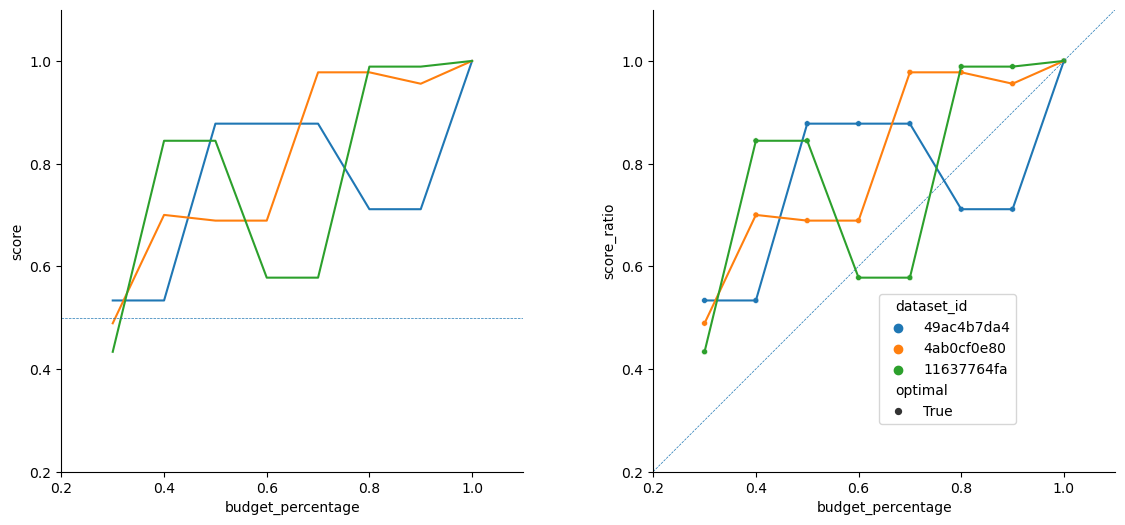

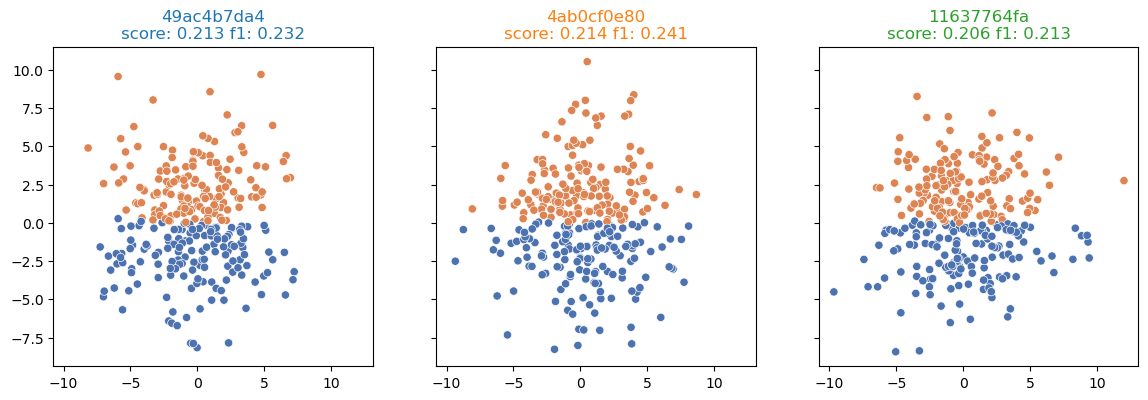

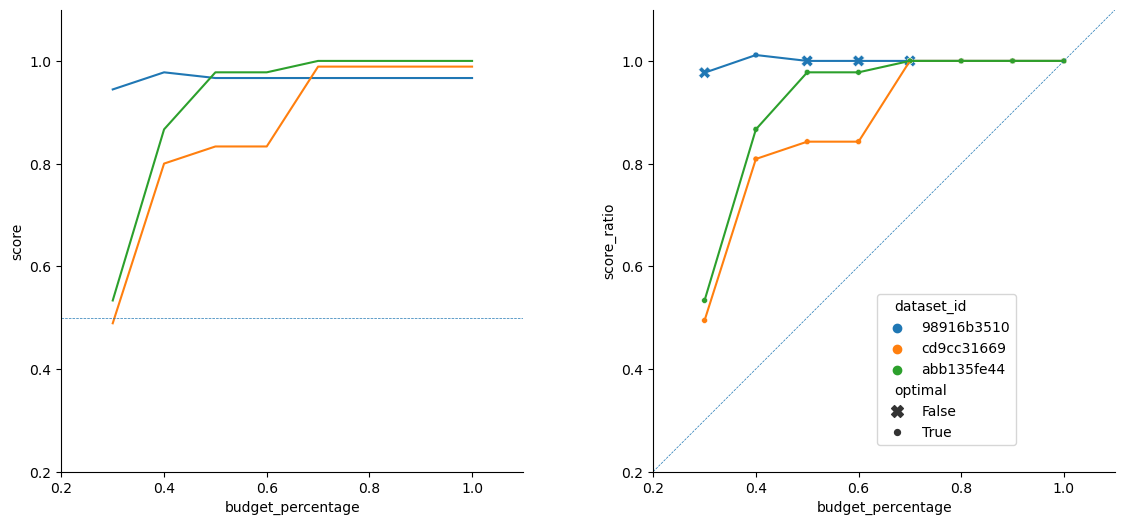

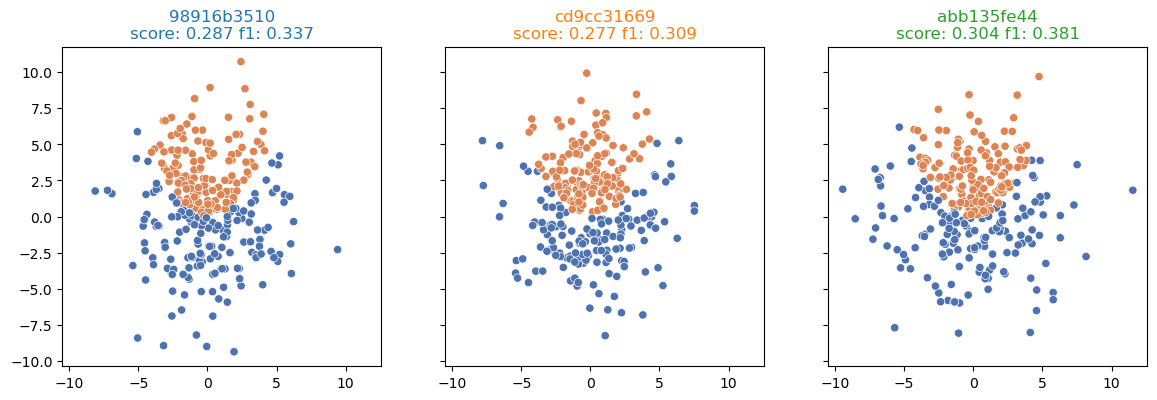

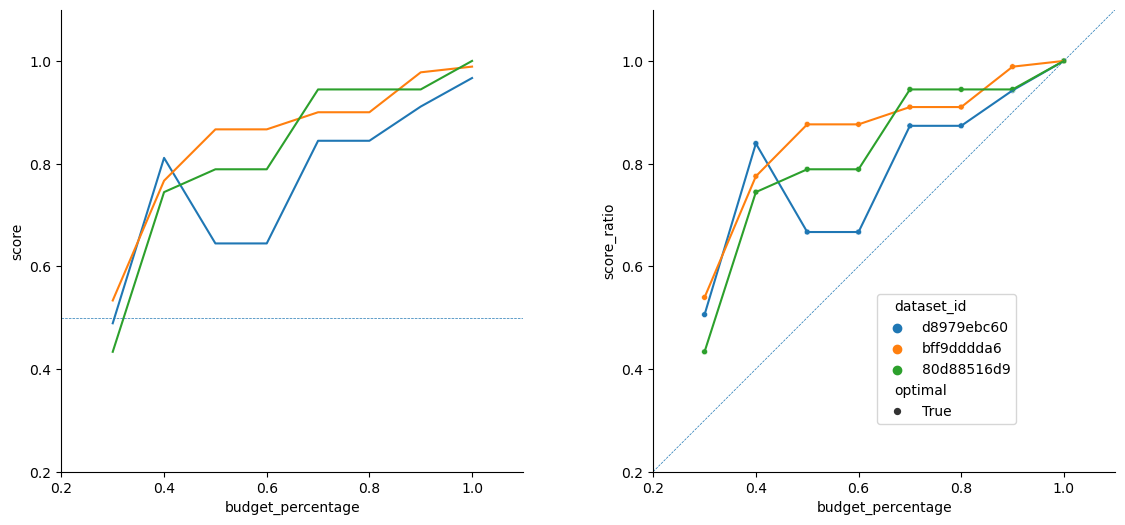

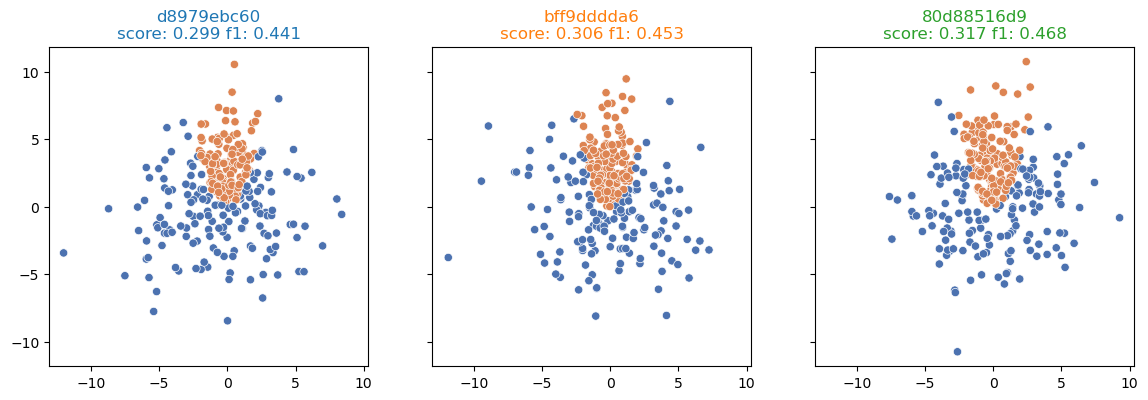

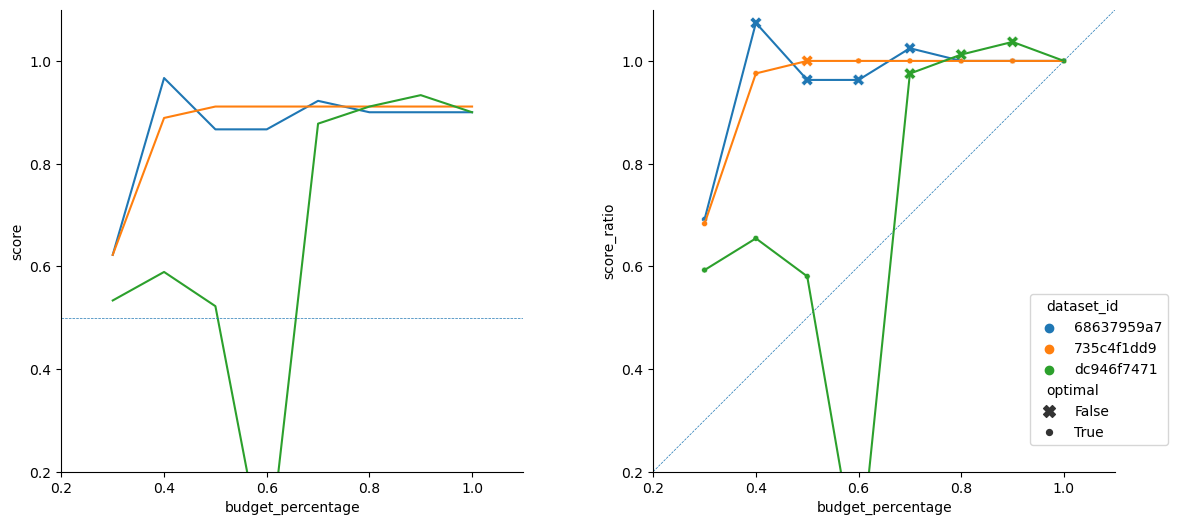

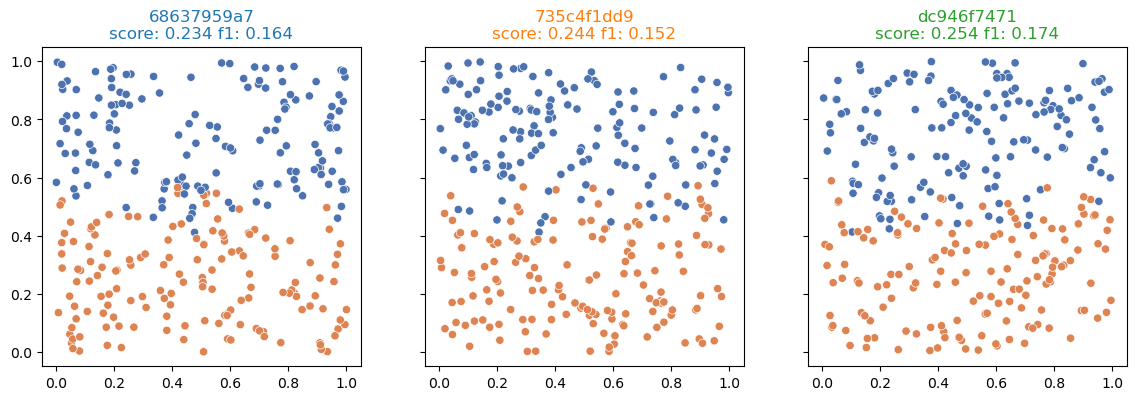

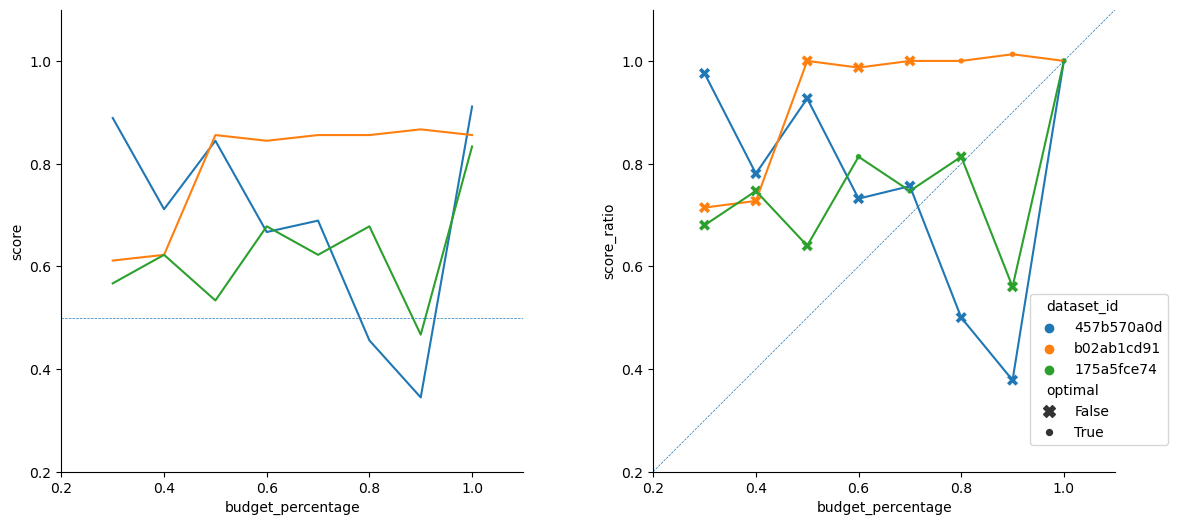

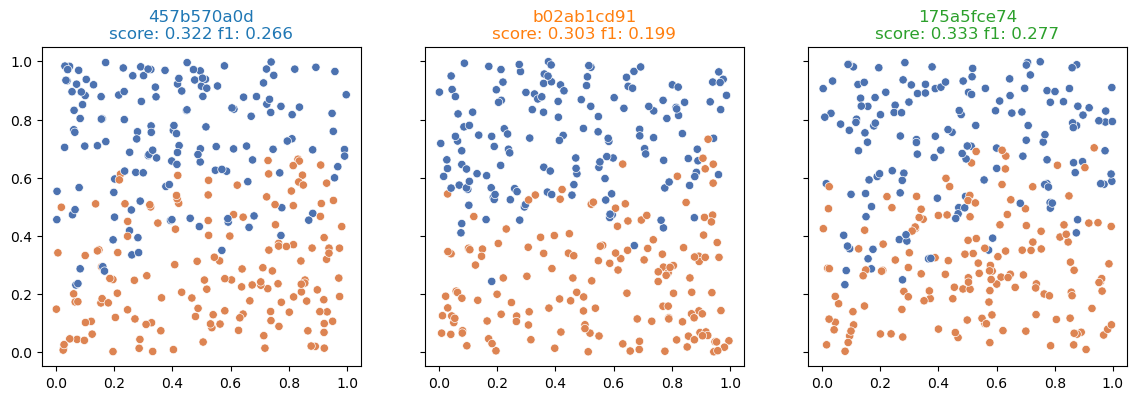

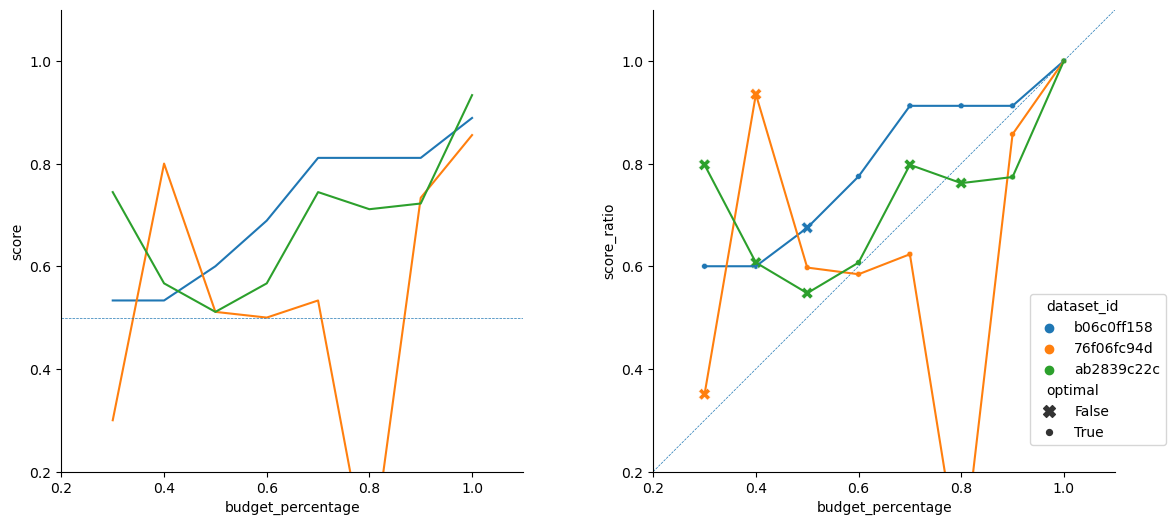

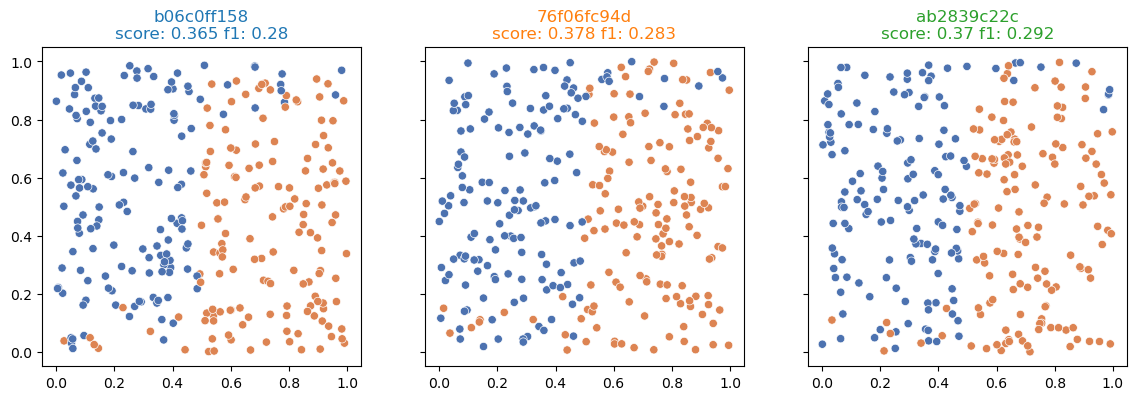

In [265]:
res_df = (
    df_success.set_index("dataset")
    .join(all_ds_info.set_index("id"), rsuffix="_ds_param")
    .reset_index()
    .rename(
        {
            "index": "dataset_id",
        },
        axis=1,
    )
)

sigmoid_res = res_df.query("a.isnull()").dropna(axis=1).copy()
pacman_res = res_df.query("rho.isnull()").dropna(axis=1).copy()

metrics = ["score", "f1"]

id_map = {}
for i, group in pacman_res.groupby(by=["a", "r", "p"]):
    ds_ids = group.dataset_id.unique().tolist()
    grouped_id = "-".join([x[-5:] for x in ds_ids])
    for ds_id in ds_ids:
        id_map[ds_id] = grouped_id
    plot_res(group, "dataset_id", metrics)
    #plot_group_ds(group)

for i, group in sigmoid_res.groupby(by=["beta", "rho", "theta"]):
    ds_ids = group.dataset_id.unique().tolist()
    grouped_id = "-".join([x[-5:] for x in ds_ids])
    for ds_id in ds_ids:
        id_map[ds_id] = grouped_id
    plot_res(group, "dataset_id", metrics)
    #plot_group_ds(group)


pacman_res["grouped_id"] = pacman_res.dataset_id.apply(lambda x: id_map[x])
sigmoid_res["grouped_id"] = sigmoid_res.dataset_id.apply(lambda x: id_map[x])

# Results all datasets

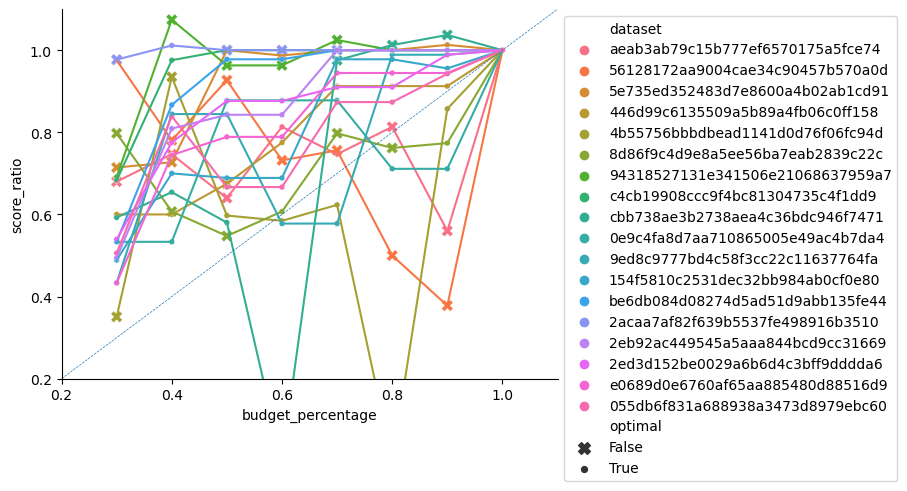

In [114]:
fig, ax = plt.subplots()

sns.lineplot(
    data=df_success,
    x="budget_percentage",
    y="score_ratio",
    hue="dataset",
    orient="x",
    legend=False,
    ax=ax,
)
g = sns.scatterplot(
    data=df_success,
    x="budget_percentage",
    y="score_ratio",
    hue="dataset",
    style="optimal",
    size="optimal",
    markers={True: "o", False: "X"},
    ax=ax,
)
plt.axline((0, 0), (1, 1), linestyle="--", linewidth=0.5)

ax.set(xlim=(0.2, 1.1))
ax.set(ylim=(0.2, 1.1))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

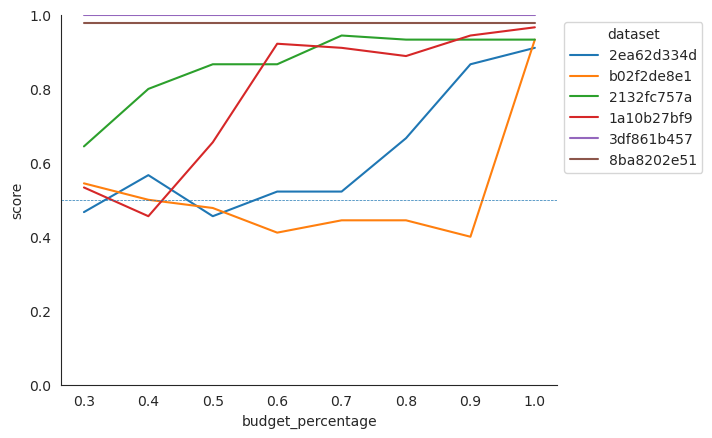

In [79]:
g = sns.lineplot(data=df_success, x="budget_percentage", y="score", hue="dataset")

plt.axhline(y=.5, linestyle="--", linewidth=.5)

g.set(ylim=(0.0, 1.0));

sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

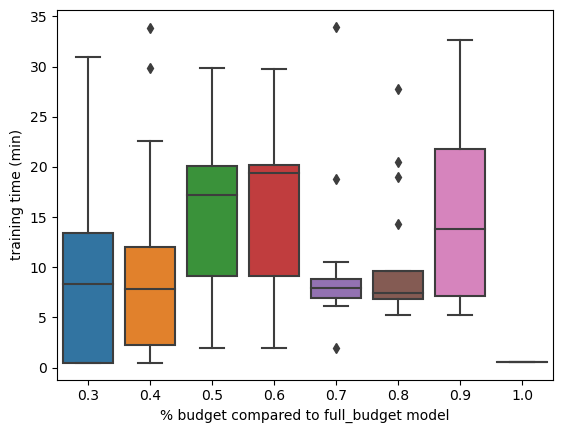

In [178]:
ax = sns.boxplot(
    data=df,
    x="budget_percentage",
    y="train_time_min"
)
ax.set(xlabel='% budget compared to full_budget model', ylabel='training time (min)');

# Same budget as unconstrained model - GridSearchCV

    full_budget_model = GridSearchCV(SVC(), params)
    100_p_model = GridSearchCV(SVC(budget=full_budget_model.num_SV), params)
    

In [185]:
import pandas as pd
from budgetsvm import optimization

df = pd.read_json("/home/anto/Downloads/experiments/results/1680714507.691396_100per_budget.json")
df

,dataset,model_UUID,model_name,optimal,params,obj_fn_value,score,budget,num_sv,train_time
0,c909c284a99cdf44d8d51d2ea62d334d,e313b4e3-bea0-4183-ae2d-718bad153d76,unconstrained,True,"{'C': 1.0, 'kernel': 'GaussianKernel(sigma=0.1)'}",56.298203,0.911111,inf,63,23.127109
1,c909c284a99cdf44d8d51d2ea62d334d,b9cb4076-d425-4ac0-b2ba-c3136d8ec27a,100perc_budget,True,"{'C': 1.0, 'kernel': 'GaussianKernel(sigma=0.1)'}",56.298203,0.911111,inf,63,22.502951
2,4866a56c176db9624e6d8bb02f2de8e1,190ba03a-058a-4eba-a2ec-3f44fbfa1b26,unconstrained,True,"{'C': 1.0, 'kernel': 'GaussianKernel(sigma=0.1)'}",50.917990,0.933333,inf,51,22.412940
3,4866a56c176db9624e6d8bb02f2de8e1,8376921d-c5b3-4b13-a3c3-67fde653de55,100perc_budget,True,"{'C': 1.0, 'kernel': 'GaussianKernel(sigma=0.1)'}",50.917990,0.933333,inf,51,22.564765
4,6340ead3f8a9ea762eaf5c2132fc757a,bae6ba03-0073-41ff-8e6b-d7c68e88eaaf,unconstrained,True,"{'C': 100.0, 'kernel': 'GaussianKernel(sigma=0...",231.114726,0.933333,inf,47,22.563301
5,6340ead3f8a9ea762eaf5c2132fc757a,e517287e-881b-4070-bbf5-e8a3b26c5423,100perc_budget,True,"{'C': 100.0, 'kernel': 'GaussianKernel(sigma=0...",231.114726,0.933333,inf,47,22.390710
6,ff89c17b0ee181abd72e691a10b27bf9,6d191cb9-a3bc-44c2-9212-74189a19737d,unconstrained,True,"{'C': 1.0, 'kernel': 'GaussianKernel(sigma=0.1)'}",41.277807,0.966667,inf,67,22.154327
7,ff89c17b0ee181abd72e691a10b27bf9,5abd087e-1acb-4bae-87d8-dbf364900db5,100perc_budget,True,"{'C': 1.0, 'kernel': 'GaussianKernel(sigma=0.1)'}",41.277807,0.966667,inf,67,22.068701
8,96ee0f04878ee282e3470b3df861b457,9ddb2599-968e-4a0b-988d-a87ae1cebcc8,unconstrained,True,"{'C': 1.0, 'kernel': 'GaussianKernel(sigma=0.1)'}",3.326407,1.000000,inf,14,21.458484
9,96ee0f04878ee282e3470b3df861b457,18d0d1c1-15d6-4763-9d65-05a1c3a89fcd,100perc_budget,True,"{'C': 1.0, 'kernel': 'GaussianKernel(sigma=0.1)'}",3.326407,1.000000,inf,14,21.599665


In [186]:
total_train_time_sec = df.train_time.sum()
df.train_time = df.train_time.div(60)
df = df.rename({"train_time": "train_time_min"}, axis=1)
df["dataset_short"] = df["dataset"].apply(lambda x: x[-10:])
df.set_index("dataset_short")

def dict_eq(d1,d2):
    return list(d1.keys()).sort() == list(d2.keys()).sort() and list(d2.items()).sort() == list(d2.items()).sort()

res = {}
for ds, group in df.groupby("dataset_short"):
    unc = group.query("model_name=='unconstrained'").iloc[0]
    bud = group.query("model_name=='100perc_budget'").iloc[0]
    
    res[ds] = {
        "same_obj": unc["obj_fn_value"] == bud["obj_fn_value"],
        "same_score": unc["score"] == bud["score"],
        "same_num_sv": unc["num_sv"] == bud["num_sv"],
        "both_optimal": unc["optimal"] and bud["optimal"],
        "same_params": dict_eq(unc["params"], bud["params"])
    }

pd.DataFrame(res).T

,same_obj,same_score,same_num_sv,both_optimal,same_params
1a10b27bf9,True,True,True,True,True
2132fc757a,True,True,True,True,True
2ea62d334d,True,True,True,True,True
3df861b457,True,True,True,True,True
8ba8202e51,True,True,True,True,True
b02f2de8e1,True,True,True,True,True


# Same budget as unconstrained model - no CV

    for each parameter combination:
        train SVC()
        train SVC(budget=100%)

In [1]:
import pandas as pd
from budgetsvm import optimization

df = pd.read_json("experiments/results/1681897515.914336_100per_budget_no_cv.json")
df

,dataset,model_name,params,score,obj_fn_value,num_sv,budget,optimal,train_time
0,aeab3ab79c15b777ef6570175a5fce74,unconstrained,"{'C': '0.1', 'kernel': 'GaussianKernel(sigma=1...",0.533333,86.277902,3,inf,True,1.373512
1,aeab3ab79c15b777ef6570175a5fce74,100perc_budget,"{'C': '0.1', 'kernel': 'GaussianKernel(sigma=1...",0.466667,1.999998,2,3.0,True,92.561426
2,aeab3ab79c15b777ef6570175a5fce74,unconstrained,"{'C': '0.1', 'kernel': 'GaussianKernel(sigma=0...",0.533333,86.277902,3,inf,True,1.133109
3,aeab3ab79c15b777ef6570175a5fce74,100perc_budget,"{'C': '0.1', 'kernel': 'GaussianKernel(sigma=0...",0.466667,1.999998,2,3.0,True,93.270331
4,aeab3ab79c15b777ef6570175a5fce74,unconstrained,"{'C': '0.1', 'kernel': 'GaussianKernel(sigma=0...",0.533333,86.277902,3,inf,True,1.118544
...,...,...,...,...,...,...,...,...,...
475,2ed3d152be0029a6b6d4c3bff9dddda6,100perc_budget,"{'C': '100', 'kernel': 'PolynomialKernel(2)'}",0.677778,31.002816,37,69.0,False,301.702354
476,2ed3d152be0029a6b6d4c3bff9dddda6,unconstrained,"{'C': '100', 'kernel': 'PolynomialKernel(5)'}",0.788889,31.123315,69,inf,True,1.479123
477,2ed3d152be0029a6b6d4c3bff9dddda6,100perc_budget,"{'C': '100', 'kernel': 'PolynomialKernel(5)'}",0.677778,31.002816,37,69.0,False,301.759815
478,2ed3d152be0029a6b6d4c3bff9dddda6,unconstrained,"{'C': '100', 'kernel': 'PolynomialKernel(10)'}",0.788889,31.123315,69,inf,True,1.407294


In [2]:
df["dataset_short"] = df["dataset"].apply(lambda x: x[-10:])
df.set_index("dataset_short")

df["params_str"] = df["params"].apply(lambda x: str(x))

def dict_eq(d1,d2):
    return list(d1.keys()).sort() == list(d2.keys()).sort() and list(d2.items()).sort() == list(d2.items()).sort()

res = {}
for idx, group in df.groupby(["dataset_short", "params_str"]):
    unc = group.query("model_name=='unconstrained'").iloc[0]
    bud = group.query("model_name=='100perc_budget'").iloc[0]
    
    res[idx] = {
        "same_obj": unc["obj_fn_value"] == bud["obj_fn_value"],
        "same_score": unc["score"] == bud["score"],
        "same_num_sv": unc["num_sv"] == bud["num_sv"],
        "both_optimal": unc["optimal"] and bud["optimal"],
        **unc[["score", "obj_fn_value", "num_sv", "budget", "optimal"]].add_prefix("un_"),
        **bud[["score", "obj_fn_value", "num_sv", "budget", "optimal"]]
    }

compare_df = pd.DataFrame(res).T
compare_df

same_obj  \
175a5fce74 {'C': '0.1', 'kernel': 'GaussianKernel()'}            False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
...                                                                ...   
bff9dddda6 {'C': '100', 'kernel': 'GaussianKernel(sigma=1e...    False   
           {'C': '100', 'kernel': 'LinearKernel()'}              False   
           {'C': '100', 'kernel': 'PolynomialKernel(10)'}        False   
           {'C': '100', 'kernel': 'PolynomialKernel(2)'}         False   
           {'C': '100', 'kernel': 'PolynomialKernel(5)'}         False   

                                                              same_score  \
175a5fce74 {'C': '0.1', 'kernel': 'GaussianKernel()'}              False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....      False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....      False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....      False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....      False   
...                                                                  ...   
bff9dddda6 {'C': '100', 'kernel': 'GaussianKernel(sigma=1e...      False   
           {'C': '100', 'kernel': 'LinearKernel()'}                False   
           {'C': '100', 'kernel': 'PolynomialKernel(10)'}          False   
           {'C': '100', 'kernel': 'PolynomialKernel(2)'}           False   
           {'C': '100', 'kernel': 'PolynomialKernel(5)'}           False   

                                                              same_num_sv  \
175a5fce74 {'C': '0.1', 'kernel': 'GaussianKernel()'}               False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       False   
...                                                                   ...   
bff9dddda6 {'C': '100', 'kernel': 'GaussianKernel(sigma=1e...       False   
           {'C': '100', 'kernel': 'LinearKernel()'}                 False   
           {'C': '100', 'kernel': 'PolynomialKernel(10)'}           False   
           {'C': '100', 'kernel': 'PolynomialKernel(2)'}            False   
           {'C': '100', 'kernel': 'PolynomialKernel(5)'}            False   

                                                              both_optimal  \
175a5fce74 {'C': '0.1', 'kernel': 'GaussianKernel()'}                 True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....         True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....         True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....         True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....         True   
...                                                                    ...   
bff9dddda6 {'C': '100', 'kernel': 'GaussianKernel(sigma=1e...        False   
           {'C': '100', 'kernel': 'LinearKernel()'}                  False   
           {'C': '100', 'kernel': 'PolynomialKernel(10)'}            False   
           {'C': '100', 'kernel': 'PolynomialKernel(2)'}             False   
           {'C': '100', 'kernel': 'PolynomialKernel(5)'}             False   

                                                               un_score  \
175a5fce74 {'C': '0.1', 'kernel': 'GaussianKernel()'}          0.533333   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....  0.533333   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....  0.533333   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....  0.533333   
           {'C': '0.1',

In [6]:
compare_df.query("same_num_sv==True")

,,same_obj,same_score,same_num_sv,both_optimal,un_score,un_obj_fn_value,un_num_sv,un_budget,un_optimal,score,obj_fn_value,num_sv,budget,optimal


In [4]:
compare_df.query("same_score==True")

same_obj  \
49ac4b7da4 {'C': '0.1', 'kernel': 'GaussianKernel()'}            False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
...                                                                ...   
68637959a7 {'C': '100', 'kernel': 'GaussianKernel(sigma=1e...    False   
           {'C': '100', 'kernel': 'LinearKernel()'}              False   
           {'C': '100', 'kernel': 'PolynomialKernel(10)'}        False   
           {'C': '100', 'kernel': 'PolynomialKernel(2)'}         False   
           {'C': '100', 'kernel': 'PolynomialKernel(5)'}         False   

                                                              same_score  \
49ac4b7da4 {'C': '0.1', 'kernel': 'GaussianKernel()'}               True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       True   
...                                                                  ...   
68637959a7 {'C': '100', 'kernel': 'GaussianKernel(sigma=1e...       True   
           {'C': '100', 'kernel': 'LinearKernel()'}                 True   
           {'C': '100', 'kernel': 'PolynomialKernel(10)'}           True   
           {'C': '100', 'kernel': 'PolynomialKernel(2)'}            True   
           {'C': '100', 'kernel': 'PolynomialKernel(5)'}            True   

                                                              same_num_sv  \
49ac4b7da4 {'C': '0.1', 'kernel': 'GaussianKernel()'}               False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       False   
...                                                                   ...   
68637959a7 {'C': '100', 'kernel': 'GaussianKernel(sigma=1e...       False   
           {'C': '100', 'kernel': 'LinearKernel()'}                 False   
           {'C': '100', 'kernel': 'PolynomialKernel(10)'}           False   
           {'C': '100', 'kernel': 'PolynomialKernel(2)'}            False   
           {'C': '100', 'kernel': 'PolynomialKernel(5)'}            False   

                                                              both_optimal  \
49ac4b7da4 {'C': '0.1', 'kernel': 'GaussianKernel()'}                 True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....         True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....         True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....         True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....         True   
...                                                                    ...   
68637959a7 {'C': '100', 'kernel': 'GaussianKernel(sigma=1e...         True   
           {'C': '100', 'kernel': 'LinearKernel()'}                   True   
           {'C': '100', 'kernel': 'PolynomialKernel(10)'}             True   
           {'C': '100', 'kernel': 'PolynomialKernel(2)'}              True   
           {'C': '100', 'kernel': 'PolynomialKernel(5)'}              True   

                                                               un_score  \
49ac4b7da4 {'C': '0.1', 'kernel': 'GaussianKernel()'}          0.922222   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....  0.922222   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....  0.922222   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....  0.922222   
           {'C': '0.1',

In [8]:
compare_df.query("un_score <= score and un_num_sv >= num_sv and num_sv>2")

same_obj  \
49ac4b7da4 {'C': '0.1', 'kernel': 'GaussianKernel()'}            False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=1e...    False   
           {'C': '0.1', 'kernel': 'LinearKernel()'}              False   
           {'C': '0.1', 'kernel': 'PolynomialKernel(10)'}        False   
           {'C': '0.1', 'kernel': 'PolynomialKernel(2)'}         False   
           {'C': '0.1', 'kernel': 'PolynomialKernel(5)'}         False   
           {'C': '1', 'kernel': 'GaussianKernel()'}              False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.00...    False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.00...    False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.01)'}    False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.1)'}     False   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=1e-0...    False   
           {'C': '1', 'kernel': 'LinearKernel()'}                False   
           {'C': '1', 'kernel': 'PolynomialKernel(10)'}          False   
           {'C': '1', 'kernel': 'PolynomialKernel(2)'}           False   
           {'C': '1', 'kernel': 'PolynomialKernel(5)'}           False   
           {'C': '10', 'kernel': 'GaussianKernel()'}             False   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.0...    False   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.0...    False   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.0...    False   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=0.1)'}    False   
           {'C': '10', 'kernel': 'GaussianKernel(sigma=1e-...    False   
           {'C': '10', 'kernel': 'LinearKernel()'}               False   
           {'C': '10', 'kernel': 'PolynomialKernel(10)'}         False   
           {'C': '10', 'kernel': 'PolynomialKernel(2)'}          False   
           {'C': '10', 'kernel': 'PolynomialKernel(5)'}          False   
           {'C': '100', 'kernel': 'GaussianKernel()'}            False   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=0....    False   
           {'C': '100', 'kernel': 'GaussianKernel(sigma=1e...    False   
           {'C': '100', 'kernel': 'LinearKernel()'}              False   
           {'C': '100', 'kernel': 'PolynomialKernel(10)'}        False   
           {'C': '100', 'kernel': 'PolynomialKernel(2)'}         False   
           {'C': '100', 'kernel': 'PolynomialKernel(5)'}         False   

                                                              same_score  \
49ac4b7da4 {'C': '0.1', 'kernel': 'GaussianKernel()'}               True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=0....       True   
           {'C': '0.1', 'kernel': 'GaussianKernel(sigma=1e...       True   
           {'C': '0.1', 'kernel': 'LinearKernel()'}                 True   
           {'C': '0.1', 'kernel': 'PolynomialKernel(10)'}           True   
           {'C': '0.1', 'kernel': 'PolynomialKernel(2)'}            True   
           {'C': '0.1', 'kernel': 'PolynomialKernel(5)'}            True   
           {'C': '1', 'kernel': 'GaussianKernel()'}                 True   
           {'C': '1', 'kernel': 'GaussianKernel(sigma=0.00...       True   
           {'C': '1', 'kernel': 'Gaussi